# Metadata Extraction from PDFs Using LLM
Author: [Zoumana Keita](https://www.youtube.com/@zoumdatascience)

## Introduction & workflow


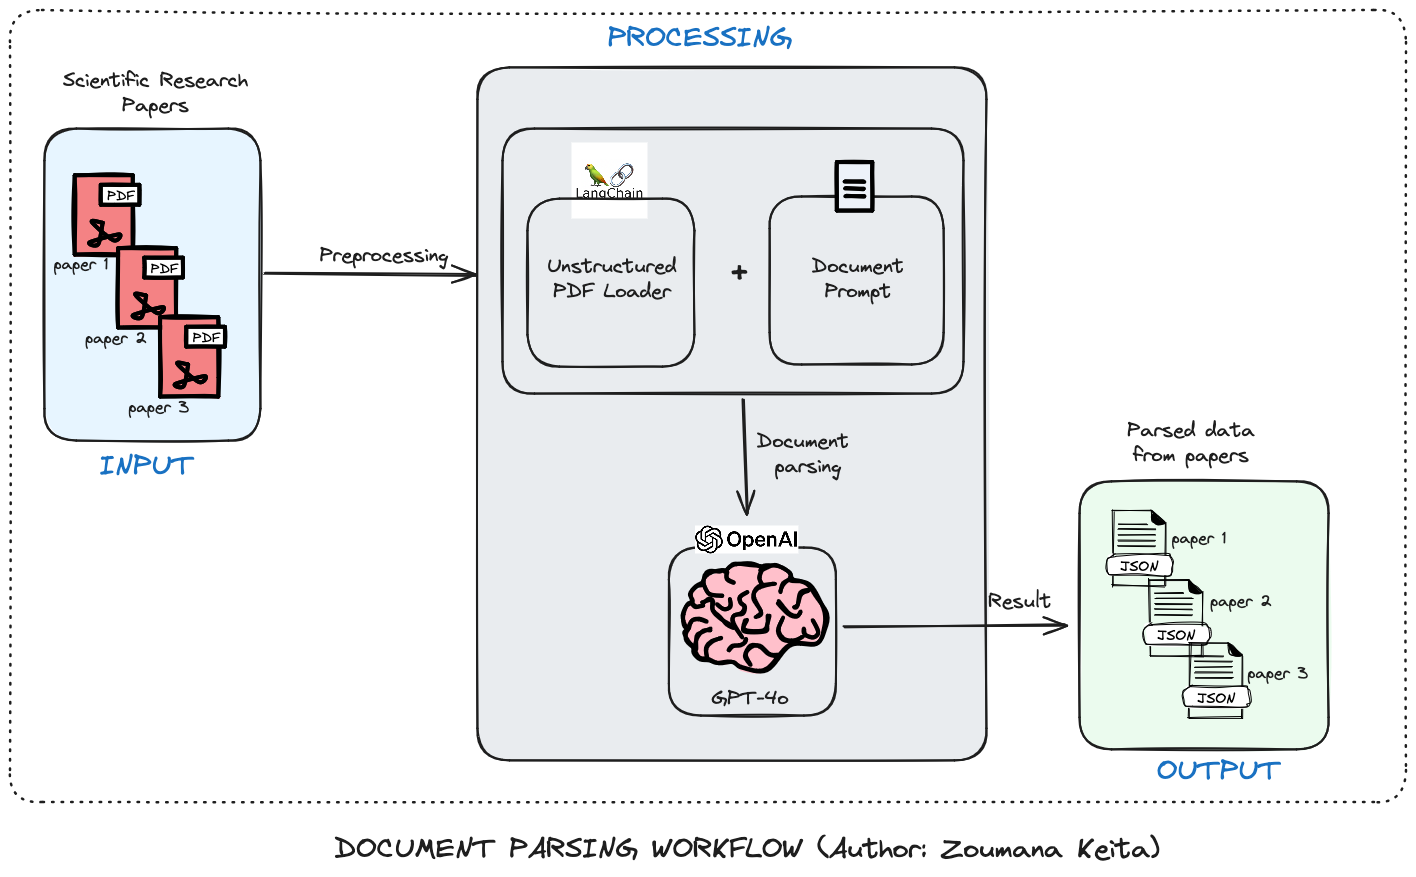

## Install libraries.  
For installations to be performed in verbose mode, we use:   
- `-qqq` option for `pip` commands.   
- `-V` option for `apt` commands.

In [1]:
%%bash

pip -qqq install pdfminer.six
pip -qqq install pillow-heif==0.3.2
pip -qqq install matplotlib
pip -qqq install unstructured-inference
pip -qqq install unstructured-pytesseract
pip -qqq install tesseract-ocr
pip -qqq install unstructured
pip -qqq install openai
pip -qqq install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  ERROR: Failed building wheel for tesseract-ocr
ERROR: Could not build wheels for tesseract-ocr, which is required to install pyproject.toml-based projects


In [2]:
%%bash
apt install -V tesseract-ocr
apt install -V libtesseract-dev

sudo apt-get update
apt-get install -V poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
   tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1)
   tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1)
The following NEW packages will be installed:
   tesseract-ocr (4.1.1-2.1build1)
   tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1)
   tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1)
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,960 kB/s)
Selecting previously unselected package tesserac





W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


## Import libraries

In [3]:
import os
import re
import json
import openai
from pathlib import Path
from openai import OpenAI
from PyPDF2 import PdfReader
from google.colab import userdata
from unstructured.partition.pdf import partition_pdf
from tenacity import retry, wait_random_exponential, stop_after_attempt

## Set up credentials

In [4]:
OPENAI_API_KEY = userdata.get('OPEN_AI_KEY')
model_ID = userdata.get('GPT_MODEL')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

client = OpenAI(api_key = OPENAI_API_KEY)

## Metadata extraction

### Helper functions

### Document processing

In [11]:
def read_prompt(prompt_path: str):
    """
    Read the prompt for research paper parsing from a text file.
    """
    with open(prompt_path, "r") as f:
        return f.read()


def extract_text_from_pdf(pdf_path: str):
    """
    Extract text content from a PDF file using the unstructured library.
    """
    elements = partition_pdf(pdf_path, strategy="hi_res")
    return "\n".join([str(element) for element in elements])

### Document parsing

The following retry is performed to avoid falling into the following rate limit issue:  
- `Error Code 429 - Rate limit reached for requests`

The `@retry` decorator provides the `extract_metadata`function with the following functionalities:   
- The function waits between 1 and 120 seconds before retrying a failed API call.   
- This waiting time increases with each retry, but always stays within this 1-120 second range.  
- This approach, called exponential backoff, helps manage API rate limits and temporary issues.   

In [8]:
@retry(wait=wait_random_exponential(min=1, max=120), stop=stop_after_attempt(10))
def completion_with_backoff(**kwargs):
    return client.chat.completions.create(**kwargs)

In [6]:
def extract_metadata(content: str, prompt_path: str, model_id: str):
    """
    Use GPT model to extract metadata from the research paper content based on the given prompt.
    """

    # Read the prompt
    prompt_data = read_prompt(prompt_path)

    try:
        response = completion_with_backoff(
            model=model_id,
            messages=[
                {"role": "system", "content": prompt_data},
                {"role": "user", "content": content}
            ],
            temperature=0.2,
        )

        response_content = response.choices[0].message.content
        if not response_content:
            print("Empty response from the model")
            return {}

        # Remove any markdown code block indicators
        response_content = re.sub(r'```json\s*', '', response_content)
        response_content = re.sub(r'\s*```', '', response_content)

        # Attempt to parse JSON
        try:
            return json.loads(response_content)
        except json.JSONDecodeError as e:
            print(f"Failed to parse JSON: {e}")
            print(f"Raw response: {response_content}")

            # Attempt to extract JSON from the response
            match = re.search(r'\{.*\}', response_content, re.DOTALL)
            if match:
                try:
                    return json.loads(match.group(0))
                except json.JSONDecodeError as jde:
                    print(f"Failed to extract valid JSON from the response: {jde}")

            return {}

    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return {}


def process_research_paper(pdf_path: str, prompt: str,
                           output_folder: str, model_id: str):
    """
    Process a single research paper through the entire pipeline.
    """
    print(f"Processing research paper: {pdf_path}")

    try:
        # Step 1: Extract text content from the PDF
        content = extract_text_from_pdf(pdf_path)
        print(f"Extracted text content from PDF: {pdf_path}")

        # Step 2: Extract metadata using GPT model
        metadata = extract_metadata(content, prompt, model_id)
        if not metadata:
            print(f"Failed to extract metadata for {pdf_path}")
            return
        print(f"Extracted metadata using {model_id} for {pdf_path}")

        # Step 3: Save the result as a JSON file
        output_filename = Path(pdf_path).stem + '.json'
        output_path = os.path.join(output_folder, output_filename)

        with open(output_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"Saved metadata to {output_path}")

    except Exception as e:
        print(f"Error processing {pdf_path}: {e}")

In [12]:
# Example for a single document

pdf_path = "./data/1706.03762v7.pdf"
prompt_path =  "./data/prompts/scientific_papers_prompt.txt"
output_folder = "./data/extracted_metadata"

process_research_paper(pdf_path, prompt_path, output_folder, model_ID)

Processing research paper: ./data/1706.03762v7.pdf


yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

Extracted text content from PDF: ./data/1706.03762v7.pdf
Extracted metadata using gpt-4o for ./data/1706.03762v7.pdf
Saved metadata to ./data/extracted_metadata/1706.03762v7.json


In [13]:
# Parse documents from a folder
def process_directory(prompt_path: str, directory_path: str, output_folder: str, model_id: str):
    """
    Process all PDF files in the given directory.
    """

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        if filename.lower().endswith('.pdf'):
            pdf_path = os.path.join(directory_path, filename)
            process_research_paper(pdf_path, prompt_path, output_folder, model_id)

### Define the arguments

In [14]:
# Define paths
prompt_path = "./data/prompts/scientific_papers_prompt.txt"
directory_path = "./data"
output_folder = "./data/extracted_metadata"

### Run the extraction

In [15]:
process_directory(prompt_path, directory_path, output_folder, model_ID)

Processing research paper: ./data/1706.03762v7.pdf
Extracted text content from PDF: ./data/1706.03762v7.pdf
Extracted metadata using gpt-4o for ./data/1706.03762v7.pdf
Saved metadata to ./data/extracted_metadata/1706.03762v7.json
Processing research paper: ./data/2301.09056v1.pdf
Extracted text content from PDF: ./data/2301.09056v1.pdf
Extracted metadata using gpt-4o for ./data/2301.09056v1.pdf
Saved metadata to ./data/extracted_metadata/2301.09056v1.json
